## NEP_Polarization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
from ase.io import read, write
from ase.neighborlist import neighbor_list
from scipy.stats import norm

plt.style.use(['science','ieee', 'bright'])
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False 

def polarization_analysis(filename, pmax=20, pbin=4, filetype='POSCAR', frame_interval=180):
    if filetype == 'POSCAR':
        atoms = read(filename)
        px, py, pz = polarization_analyzer(atoms, pmax, pbin)
    elif filetype == 'XYZ':
        structures = read(filename, index=slice(0, None, frame_interval))
        px, py, pz = [], [], []
        for atoms in structures:
            px_atoms, py_atoms, pz_atoms = polarization_analyzer(atoms, pmax, pbin)
            px.extend(px_atoms)
            py.extend(py_atoms)
            pz.extend(pz_atoms)
    return px, py, pz

def polarization_analyzer(atoms, pmax, pbin):
    cell_center = atoms.get_cell().sum(axis=0) / 2
    new_positions = atoms.get_positions() - cell_center
    atoms.set_positions(new_positions)
    
    distances_from_center = np.linalg.norm(atoms.get_positions(), axis=1)

    ge_indices = [i for i, e in enumerate(atoms.get_chemical_symbols()) if e == 'Ge' and distances_from_center[i] <= pmax]
    te_indices = [i for i, e in enumerate(atoms.get_chemical_symbols()) if e == 'Te' and distances_from_center[i] <= (pmax + pbin)]

    new_indices = ge_indices + te_indices
    new_atoms = atoms[new_indices]
    new_positions = new_atoms.get_positions()
    cell = new_atoms.get_cell()

    new_ge_indices = [i for i, e in enumerate(new_atoms.get_chemical_symbols()) if e == 'Ge']
    new_te_indices = [i for i, e in enumerate(new_atoms.get_chemical_symbols()) if e == 'Te']

    i_list, j_list = neighbor_list('ij', new_atoms, 4)
    distances = new_atoms.get_all_distances(mic=True)

    polarization_vectors = []

    for ge_index in new_ge_indices:
        neighbors = [(j_list[k], distances[ge_index, j_list[k]]) for k in range(len(i_list)) if i_list[k] == ge_index and j_list[k] in new_te_indices]

        neighbors = sorted(neighbors, key=lambda x: x[1])[:6]
        nearest_te_indices = [index for index, _ in neighbors]

        ge_position = new_positions[ge_index]
        te_positions = new_positions[nearest_te_indices]
        te_displacements = te_positions - ge_position

        te_displacements -= np.round(te_displacements @ np.linalg.inv(cell)) @ cell
        te_positions = ge_position + te_displacements

        center_of_mass = np.mean(te_positions, axis=0)

        polarization_vector = ge_position - center_of_mass
        polarization_vectors.append((ge_index, polarization_vector, nearest_te_indices))

    px = [vec[1][0] for vec in polarization_vectors]
    py = [vec[1][1] for vec in polarization_vectors]
    pz = [vec[1][2] for vec in polarization_vectors]
    return px, py, pz

def _scatter(ax, px, py, color, label, **kwargs):
    ax.scatter(px, py, color=color, label=label, **kwargs)
    
def _scatter_set(ax, xlabel, ylabel):
    ax.axvline(0, c='k', alpha=0.5, linestyle='--')
    ax.axhline(0, c='k', alpha=0.5, linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(-1.05, 1.05) 
    ax.legend(loc="upper right", ncol=1)
    
def _kdeplot(ax, px, color, label, **kwargs):
    # sns.kdeplot(x=px, ax=ax, common_norm=True, color=color, label=label, **kwargs)
    
    mu, std = np.mean(px), np.std(px)
    x = np.linspace(mu - 3*std, mu + 3*std, 100)
    y = norm.pdf(x, mu, std)
    ax.plot(x, y, color=color, label=label, **kwargs) # label=r'{}: $\mu$={:.2f}'.format(label, mu)
    
def _kdeplot_set(ax, xlabel, ylabel):
    ax.axvline(0, c='k', alpha=0.5, linestyle='--')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_xlim(-1.05, 1.05)
    ax.set_ylim(0, 3) 
    ax.legend(loc="upper right", ncol=1)
    
def plot2d(polar, colors, **kwargs):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6), dpi=300)
    ax1, ax2, ax3, ax4, ax5, ax6 = axes.flatten()

    for i, (label, p) in enumerate(polar.items()):
        px, py, pz = p[0], p[1], p[2]
        color = colors[i % len(colors)]
        _kdeplot(ax1, px, color, label)
        _kdeplot(ax2, py, color, label)
        _kdeplot(ax3, pz, color, label)
        _scatter(ax4, px, py, color, label, **kwargs)
        _scatter(ax5, px, pz, color, label, **kwargs)
        _scatter(ax6, py, pz, color, label, **kwargs)
        
    _kdeplot_set(ax1, 'X', 'Distribution')
    _kdeplot_set(ax2, 'Y', 'Distribution')
    _kdeplot_set(ax3, 'Z', 'Distribution')
    
    _scatter_set(ax4, 'Px', 'Py')
    _scatter_set(ax5, 'Px', 'Pz')
    _scatter_set(ax6, 'Py', 'Pz')
    
    plt.tight_layout()
    plt.savefig('./polarization.png', bbox_inches='tight', dpi=300)

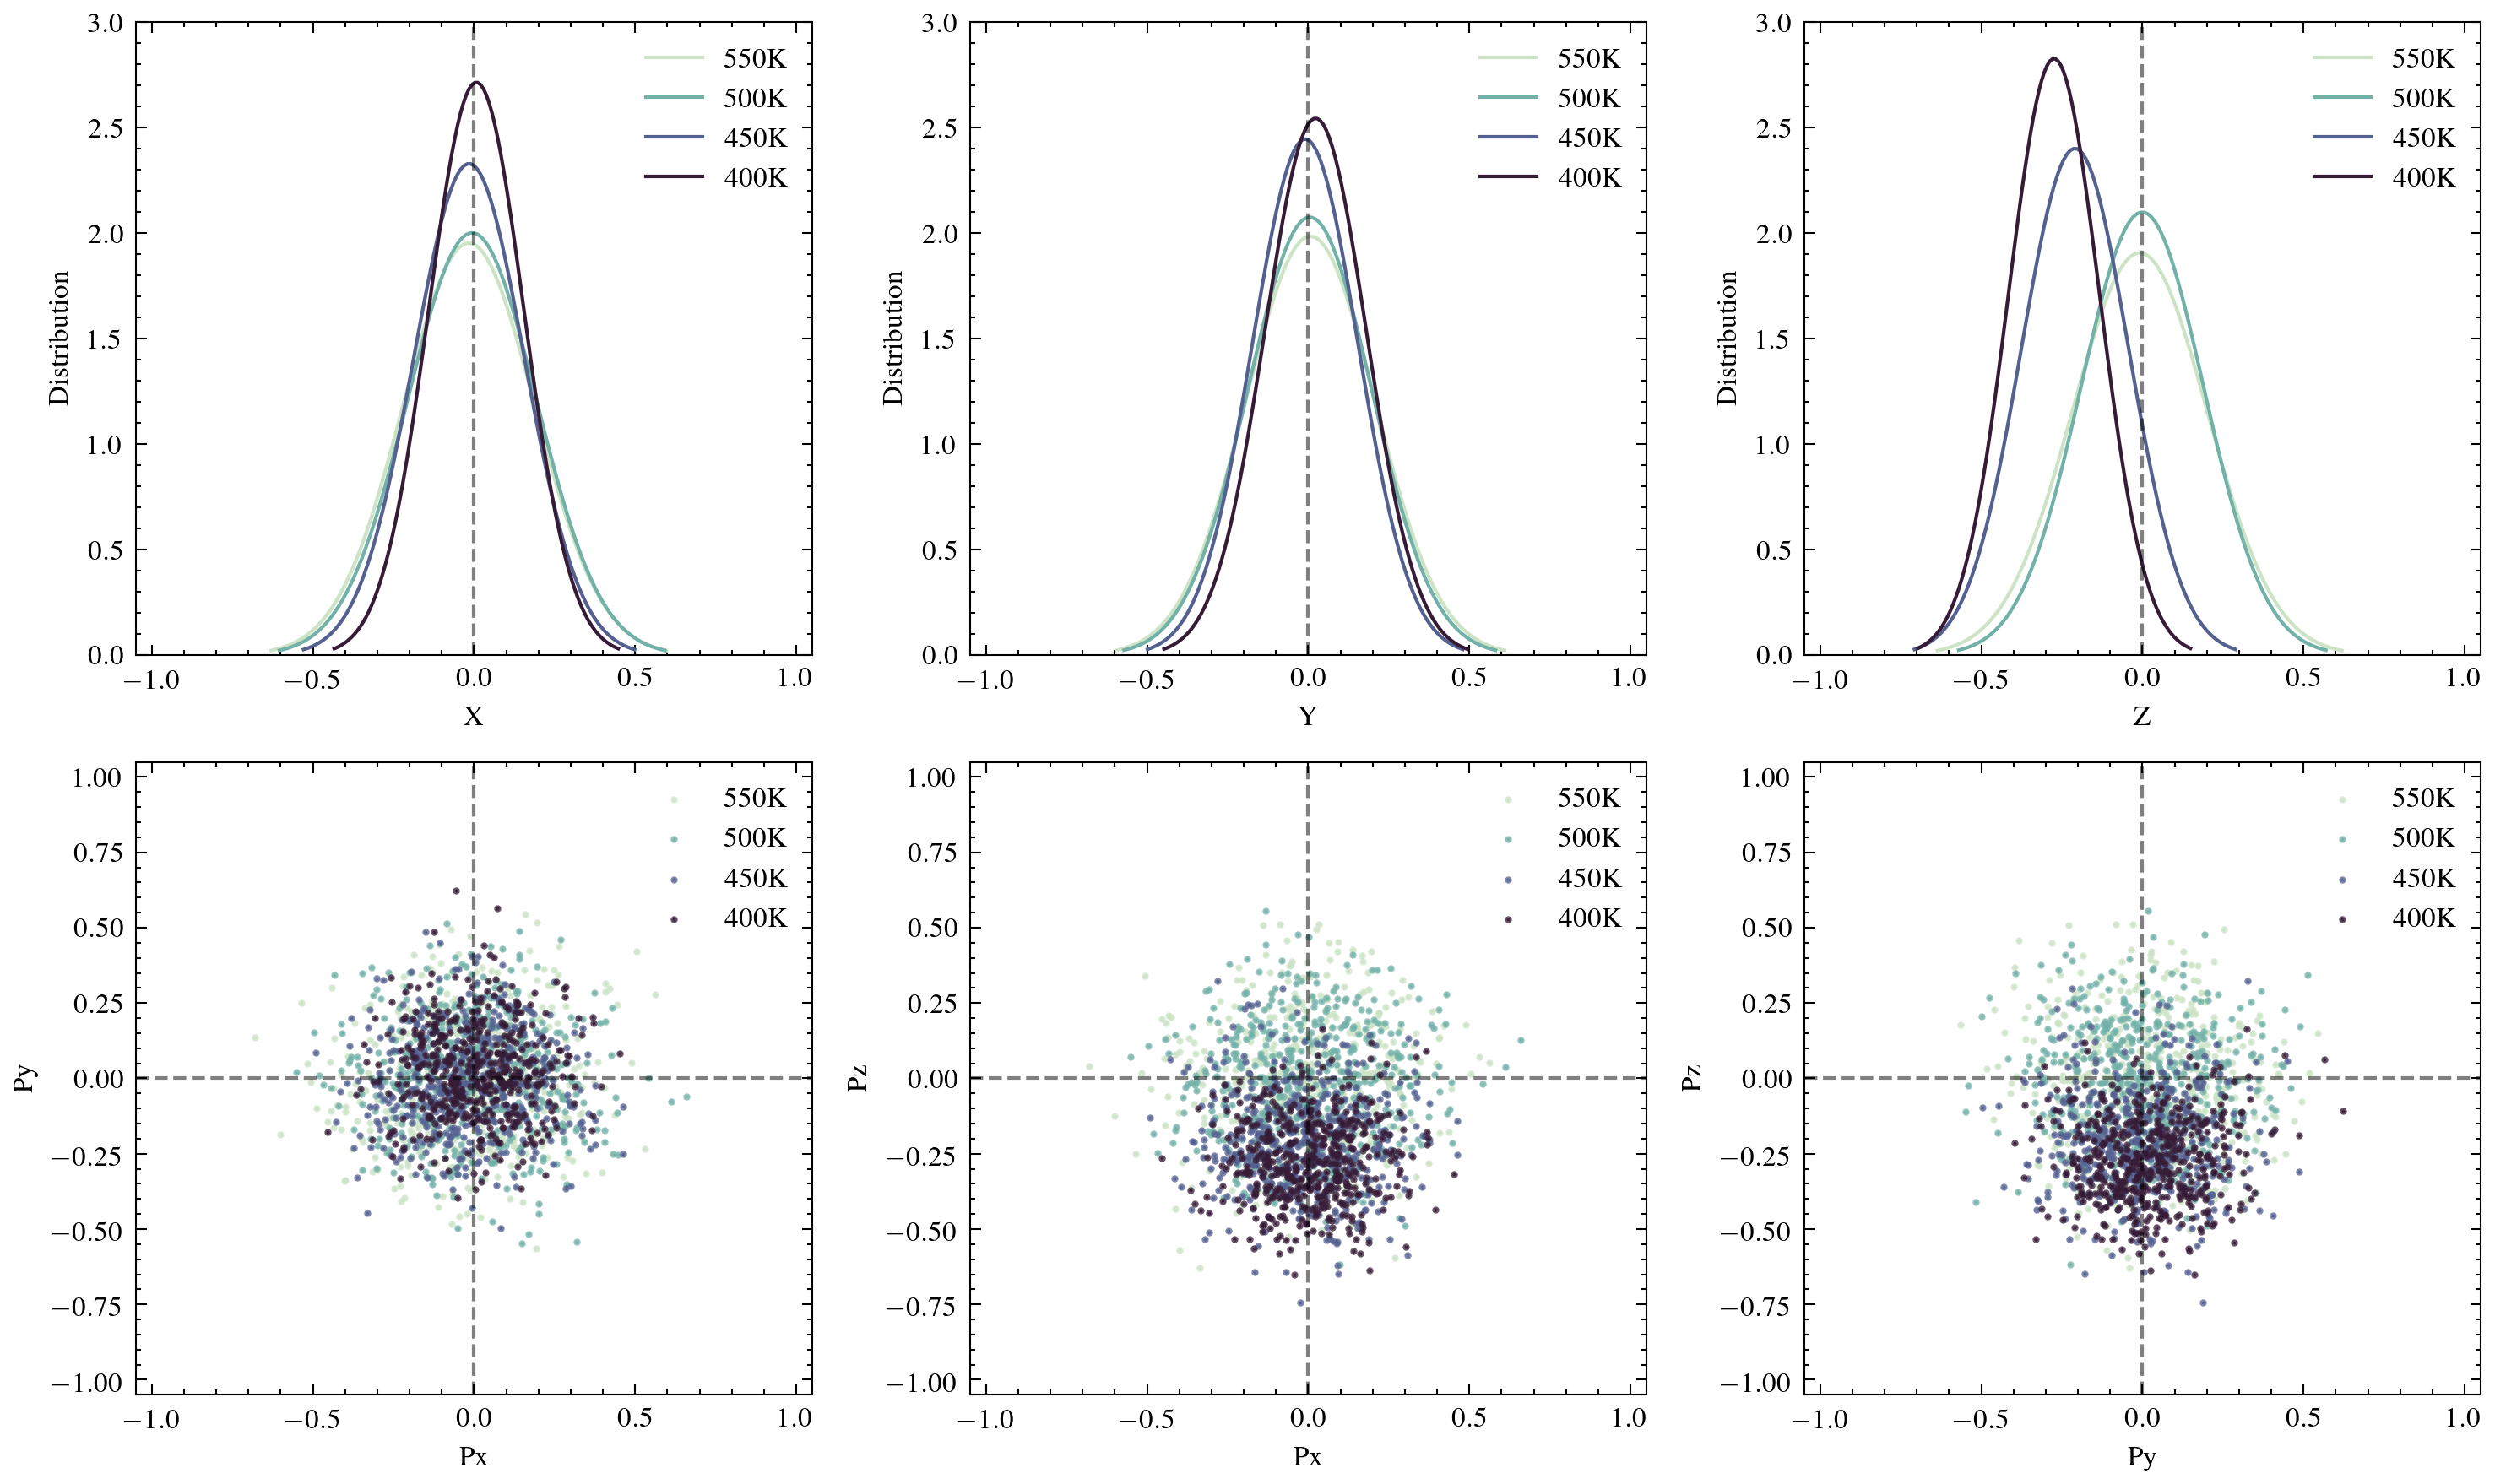

In [2]:
def main():
    polar = dict()
    polar["550K"] = polarization_analysis("../split_xyz_files/split_550.xyz", filetype='XYZ')
    polar["500K"] = polarization_analysis("../split_xyz_files/split_500.xyz", filetype='XYZ')
    polar["450K"] = polarization_analysis("../split_xyz_files/split_450.xyz", filetype='XYZ')
    polar["400K"] = polarization_analysis("../split_xyz_files/split_400.xyz", filetype='XYZ')
    color = sns.cubehelix_palette(len(polar), start=.75,rot=-.75)
    plot2d(polar, color, s=1, alpha=0.75)
    
if __name__ == '__main__':
    main()